In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

In /home/kubuntu1804/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kubuntu1804/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kubuntu1804/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kubuntu1804/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kubuntu1804/.local/lib/python3.6/site-packa

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 3.0  # final time
rA = 1.5   # maximum interaction distance

seed=67

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': muR*ratio, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a': 7.51}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [4]:
force_names = ['cubic', 'pw. quad.', 'GLS']
solver_names = ['EF', 'EB']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.'}

In [5]:
models_ef = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), ef.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), ef.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), ef.solve_ivp, 1)}
models_eb = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), eb.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), eb.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), eb.solve_ivp, 1)}
model_dicts = {'EF': models_ef, 'EB': models_eb}

In [6]:
# Initial condition
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [1.15], proliferating=False)]

In [7]:
t_data_ref = np.linspace(0, tf, 10000+1)


In [8]:
dt = 1e-4
t_data_ref = np.arange(0, tf, dt)
#t_data_ref = np.linspace(0, tf, 10000+1)

#t_data_ref=[0,tf]
ref_sol_dicts = {}
for solver in solver_names:
    models = model_dicts[solver]
    ref_sols = {}
    for force in force_names: 
        #params_solver = {'EF':{'dt': 0.0001}, 'EB': {'dt': 0.0001, 'jacobian': models[force].jacobian}}
        params_solver = {'EF':{'dt': dt}, 'EB': {'dt': dt}}
        (t_data, history) = models[force].simulate(cell_list, t_data_ref, params[force], params_solver[solver], seed=seed)
        ref_sols[force] = (t_data, np.array([np.abs(clt[1].position - clt[0].position) for clt in history]))
    ref_sol_dicts[solver] = ref_sols

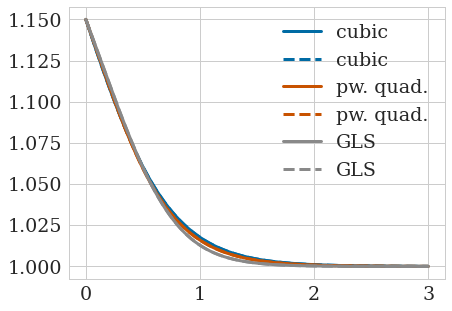

In [9]:
# plot the reference solution
for force in force_names:
    plt.plot(ref_sol_dicts['EF'][force][0], ref_sol_dicts['EF'][force][1], label=force, color=colors[force])
    plt.plot(ref_sol_dicts['EB'][force][0], ref_sol_dicts['EB'][force][1], label=force, linestyle='--', color=colors[force])
plt.legend()

In [10]:
dt_values = [0.001*1.25**n for n in range(0, 28)]

In [11]:
sol_dicts = {}

In [12]:
n = 5
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(tf/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        av_time = 0
        for j in np.arange(n):
            start = time.time()
            (t, history) = model_dicts['EF'][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
            exec_time = time.time() - start
            av_time = av_time + exec_time
        av_time = av_time / n
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        t_ref = ref_sol_dicts['EF'][force][0]
        inter = np.interp(t_ref, t, np.squeeze(y))
        ref = np.squeeze(ref_sol_dicts['EF'][force][1])
        sol[force].append((np.linalg.norm(inter-ref)/np.linalg.norm(ref), av_time))
sol_dicts['EF'] = sol

[3001, 0.001]
[2401, 0.00125]
[1921, 0.0015625]
[1537, 0.001953125]
[1229, 0.00244140625]
[984, 0.0030517578125]
[787, 0.003814697265625]
[630, 0.00476837158203125]
[504, 0.0059604644775390625]
[403, 0.007450580596923828]
[323, 0.009313225746154785]
[258, 0.011641532182693481]
[207, 0.014551915228366852]
[165, 0.018189894035458565]
[132, 0.022737367544323206]
[106, 0.028421709430404007]
[85, 0.03552713678800501]
[68, 0.04440892098500626]
[55, 0.05551115123125783]
[44, 0.06938893903907228]
[35, 0.08673617379884035]
[28, 0.10842021724855044]
[23, 0.13552527156068805]
[18, 0.16940658945086007]
[15, 0.21175823681357508]
[12, 0.2646977960169689]
[10, 0.3308722450212111]
[8, 0.41359030627651383]


In [13]:
np.array(sol_dicts['EF']['pw. quad.'])[:,0]

array([1.59089947e-05, 2.03267209e-05, 2.58480841e-05, 3.27484831e-05,
       4.13719184e-05, 5.21479847e-05, 6.56130179e-05, 8.24364263e-05,
       1.03453362e-04, 1.29705268e-04, 1.62490076e-04, 2.03424016e-04,
       2.54517993e-04, 3.18270428e-04, 3.97781432e-04, 4.96889516e-04,
       6.20335355e-04, 7.73955553e-04, 9.64905905e-04, 1.20190990e-03,
       1.49552560e-03, 1.85840400e-03, 2.30549294e-03, 2.85410359e-03,
       3.52372679e-03, 4.33552606e-03, 5.31209393e-03, 6.49893373e-03])

In [14]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force])[:, 0] > 0.01)[0][0]]])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force])[:, 0] > 0.1)[0][0]]])

In [15]:
n = 5
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(tf/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        av_time = 0
        for j in np.arange(n):
            start = time.time()
            (t, history) = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
            exec_time = time.time() - start
            av_time = av_time + exec_time
        av_time = av_time / n
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        t_ref = ref_sol_dicts['EB'][force][0]
        inter = np.interp(t_ref, t, np.squeeze(y))
        ref = np.squeeze(ref_sol_dicts['EB'][force][1])
        sol[force].append((np.linalg.norm(inter-ref)/np.linalg.norm(ref), av_time))
sol_dicts['EB'] = sol

[3001, 0.001]
[2401, 0.00125]
[1921, 0.0015625]
[1537, 0.001953125]
[1229, 0.00244140625]
[984, 0.0030517578125]
[787, 0.003814697265625]
[630, 0.00476837158203125]
[504, 0.0059604644775390625]
[403, 0.007450580596923828]
[323, 0.009313225746154785]
[258, 0.011641532182693481]
[207, 0.014551915228366852]
[165, 0.018189894035458565]
[132, 0.022737367544323206]
[106, 0.028421709430404007]
[85, 0.03552713678800501]
[68, 0.04440892098500626]
[55, 0.05551115123125783]
[44, 0.06938893903907228]
[35, 0.08673617379884035]
[28, 0.10842021724855044]
[23, 0.13552527156068805]
[18, 0.16940658945086007]
[15, 0.21175823681357508]
[12, 0.2646977960169689]
[10, 0.3308722450212111]
[8, 0.41359030627651383]


In [ ]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force])[:, 0] > 0.01)[0][0]]])

In [ ]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force])[:, 0] > 0.1)[0][0]]])

In [16]:
dt_values

[0.001,
 0.00125,
 0.0015625,
 0.001953125,
 0.00244140625,
 0.0030517578125,
 0.003814697265625,
 0.00476837158203125,
 0.0059604644775390625,
 0.007450580596923828,
 0.009313225746154785,
 0.011641532182693481,
 0.014551915228366852,
 0.018189894035458565,
 0.022737367544323206,
 0.028421709430404007,
 0.03552713678800501,
 0.04440892098500626,
 0.05551115123125783,
 0.06938893903907228,
 0.08673617379884035,
 0.10842021724855044,
 0.13552527156068805,
 0.16940658945086007,
 0.21175823681357508,
 0.2646977960169689,
 0.3308722450212111,
 0.41359030627651383]

In [17]:
sol_dicts['EF']['GLS']

[(1.4264462848553242e-05, 0.2667702198028564),
 (1.8225416814324682e-05, 0.19311990737915039),
 (2.317584226002018e-05, 0.28087143898010253),
 (2.9362613446233153e-05, 0.12563624382019042),
 (3.70940759305073e-05, 0.11647515296936035),
 (4.6755273345685315e-05, 0.0841142177581787),
 (5.8826875436101956e-05, 0.06696119308471679),
 (7.390872545950479e-05, 0.05494332313537598),
 (9.274907061634796e-05, 0.04162893295288086),
 (0.00011628078412935112, 0.034053897857666014),
 (0.0001456661401197593, 0.031157302856445312),
 (0.00018235200134981982, 0.03935341835021973),
 (0.00022813756903332635, 0.023413801193237306),
 (0.00028525710568514225, 0.024573469161987306),
 (0.00035648030475096774, 0.010889673233032226),
 (0.00044523282154183846, 0.014013242721557618),
 (0.0005557391893460026, 0.008512353897094727),
 (0.0006931890823843903, 0.01203150749206543),
 (0.0008639251321889031, 0.009217977523803711),
 (0.0010756452258733078, 0.009687423706054688),
 (0.0013376023279162198, 0.0095196247100830

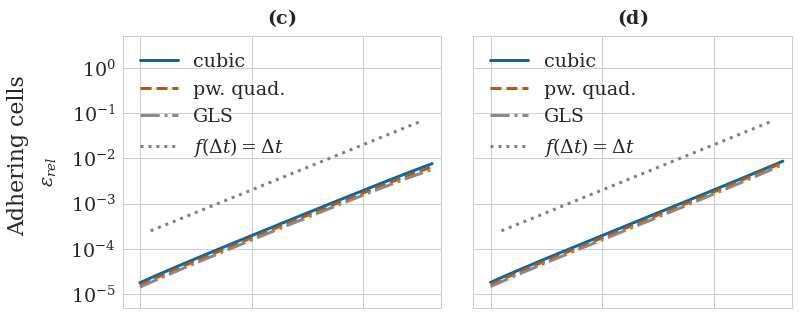

In [18]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), sharey=True, gridspec_kw={'wspace': 0.1})

# ax1
for force in force_names: 
    ax1.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,0], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,1], label=force+' y')
ax1.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax1.legend(loc='upper left')
#plt.legend()
#ax1.set(xlabel='$\Delta t$')
ax1.set_title(r'$\bf{(c)}$')
ax1.set(ylabel='$\epsilon_{rel}$')
ax1.set_xlim([7*1e-4, 5*1e-1])
ax1.set_ylim([5*1e-6, 5*1e-0])
ax1.set_xticklabels([])
#ax1.set_ylim([5*1e-8, 5*1e-0])
#ax1.text(0.0025, 25, 'Forward Euler method', fontsize=22)
ax1.text(0.000065, 0.00025, 'Adhering cells', fontsize=22, rotation='vertical')


#ax2
for force in force_names: 
    ax2.loglog(dt_values, np.array(sol_dicts['EB'][force])[:,0], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
ax2.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax2.legend(loc='upper left')
#ax2.set(xlabel='$\Delta t$')
ax2.set_xlim([7*1e-4, 5*1e-1])
ax2.set_title(r'$\bf{(d)}$')
ax2.set_xticklabels([])

#ax2.text(0.0025, 25, 'Backward Euler method', fontsize=22)
plt.savefig('convergence_study_EB_adhesion.pdf', bbox_inches='tight')

In [ ]:
end_index = {'cubic': -1, 'pw. quad.': -1, 'GLS': -1}

for force in force_names:
    plt.loglog(np.array(sol_dicts['EF'][force])[:end_index[force],0], np.array(sol_dicts['EF'][force])[:end_index[force],1], label=force, color=colors[force])
    plt.loglog(np.array(sol_dicts['EB'][force])[:,0], np.array(sol_dicts['EB'][force])[:,1], linestyle='--', color=colors[force])

plt.xlabel('$\epsilon_{rel}$')    
plt.ylabel('Wall time [s]')
plt.ylim([5*1e-4, 5*1e-0])
plt.legend()
plt.savefig('exec_time_EB_adhesion.pdf', bbox_inches='tight')